# H2o Model Training

## Setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
ipython = get_ipython()
ipython.magic("load_ext google.cloud.bigquery")

In [3]:
# import sys
# sys.path.append('/home/jovyan/projects/common')

In [4]:
# os.chdir('/home/jovyan/projects/model_h1_training_age_segment/model_sample_training')
# os.getcwd()

In [5]:
import pandas as pd
import os
import shutil
import pytz
from datetime import datetime
import yaml
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import evaluation_utilities
import utilities
import h2o_cluster
import model_performance

import logging

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import normalize

from verta import Client

In [6]:
pd.set_option('display.max_rows', 50)
pd.option_context('display.max_columns', 50)

In [7]:
logger = utilities.get_logger(level='INFO')

# Load Config

In [243]:
####################################################
config_file = "./config_cluster_modeldb.yaml"
####################################################

with open(config_file) as f:
    model_config = yaml.load(f, Loader=yaml.SafeLoader)

# Cluster Config
CLUSTER_NAME = model_config['H2O_CLUSTER_CONFIG']['CLUSTER_NAME']
CLUSTER_NODE_COUNT = model_config['H2O_CLUSTER_CONFIG']['NODE_COUNT']
NODE_CPU = model_config['H2O_CLUSTER_CONFIG']['NODE_CPU']
NODE_MEMGB = model_config['H2O_CLUSTER_CONFIG']['NODE_MEMGB']

# ModelDB Config
HOST = model_config['MODELDB_CONFIG']['HOST']
ARTIFACTS_FOLDER = model_config['MODELDB_CONFIG']['ARTIFACTS_FOLDER']
SAVED_MODEL_FOLDER = model_config['MODELDB_CONFIG']['SAVED_MODEL_FOLDER']
PROJECT_NAME = model_config['MODELDB_CONFIG']['PROJECT_NAME']
EXPERIMENT_NAME = model_config['MODELDB_CONFIG']['EXPERIMENT_NAME']
EXPERIMENT_RUN_NAME = model_config['MODELDB_CONFIG']['EXPERIMENT_RUN_NAME']
EXPERIMENT_RUN_TAGS = model_config['MODELDB_CONFIG']['EXPERIMENT_RUN_TAGS']



####################################################
config_file = "./config_model_data.yaml"
####################################################

with open(config_file) as f:
    model_data = yaml.load(f, Loader=yaml.SafeLoader)
    
    
# GCS
MODEL_GCS = model_data['GCS']['MODEL_GCS']
OUTPUT_GCS = model_data['GCS']['OUTPUT_GCS']

# DATA BLOB <<== select blob name
    
TRAIN_BLOB = model_data['MODEL_DATA_PATH']['all_features_tf_classification_v07__v6']['train']
TEST_BLOB = model_data['MODEL_DATA_PATH']['all_features_tf_classification_v07__v4']['test_diff']
TEST_CHAMPION_BLOB = model_data['MODEL_DATA_PATH']['all_features_tf_classification_v07__v4']['test_diff_champion']

# COLUMNS AND VARIABLES
INDEX_COLUMNS = model_data['INDEX_COLUMNS']

STRING_COLS = model_data['COLUMNS_TYPE']['STRING_COLS']
NUMERICAL_COLS = model_data['COLUMNS_TYPE']['NUMERICAL_COLS']
# CATEGORICAL_COLS = model_data['COLUMNS_TYPE']['CATEGORICAL_COLS']

# MODEL VARIABLES
RESPONSE_COL = model_data['RESPONSE_COL']
POSITIVE_LABELS = model_data['POSITIVE_LABELS']
NEGATIVE_LABELS = model_data['NEGATIVE_LABELS']
LIST_TO_REMOVE_FROM_PREDICTORS = model_data['LIST_TO_REMOVE_FROM_PREDICTORS']

TARGET_NAMES = model_data['TARGET_NAMES']



####################################################
config_file = 'config_model_parameters.yaml'
####################################################
# MODEL PROPERTIES AND HYPERPARAMETERS

with open(config_file) as f:
    model_param = yaml.load(f, Loader=yaml.SafeLoader)

model_properties = model_param['MODEL_PROPERTIES']
hyperparam_args = model_param['HYPER_DRF']['default']
model_properties.update(hyperparam_args)


# Functions

In [244]:
def get_column_types_from_data_blob(blob_path, pattern= '.*0000000\.csv', string_columns='', numerical_columns='', categorical_columns='', default_type='categorical'):
    """
    If all types are clearly defined then set default_category=None.
    If two types are clearly defined then set default_category as the last category.
    default categories: 'string', 'numeric', 'categorical'
    """
    temp = h2o.import_file(path=blob_path, pattern= pattern)
    columns = temp.columns
    h2o.remove(temp)
    
    
    col_types = [
    'string' if col in string_columns
    else 'numeric' if col in numerical_columns
    else 'categorical' if col in categorical_columns
    else default_type
    for col in columns
    ]
    
    return columns, col_types

# ModelDB Setting

In [245]:
# EXPERIMENT_RUN_NAME = "Train on NT events only - Predict Live events wo event_position - Base"

print(HOST)
print(PROJECT_NAME)
print(EXPERIMENT_NAME)
print(EXPERIMENT_RUN_NAME)

https://modeldb.mlp.ml.gce.z8s.io/
P13N_daily_email_model_h5
H2O DRF - Relevent negative data for training
treatment2 - vf, deeper tree parameter setting


In [246]:
# # Manualy 
# EXPERIMENT_RUN_NAME = "treatment1 - vf"
# modeldb_expt_run = client.get_experiment_run(EXPERIMENT_RUN_NAME)

In [247]:
#Connecting to the client API
client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)

# Create the experiment run
modeldb_expt_run =  client.set_experiment_run(name=f'{EXPERIMENT_RUN_NAME}') 

connection successfully established
got existing Project: P13N_daily_email_model_h5
got existing Experiment: H2O DRF - Relevent negative data for training
got existing ExperimentRun: treatment2 - vf, deeper tree parameter setting


# Initiate a H2O Cluster

In [248]:
h2o_cluster.list_clusters()

[H2OCluster(name='h2o-modelh5-1', version='3.28.1.2', ready=True, count=5, cpu='7', mem='45Gi', endpoint='http://h2o-modelh5-1-h2o.jisukim.svc:54321', uiPath='/h2o/jisukim/h2o-modelh5-1', serviceAccountName='default-editor')]

## Delete clusters

In [239]:
# delete the cluster after use. 
confirm = input("Do you want to delete the h2o cluster? yes/ or any key")
if confirm.lower() == 'yes':
    h2o_cluster.delete_cluster(CLUSTER_NAME)
else:
    print("Cancellecd")

Do you want to delete the h2o cluster? yes/ or any key yes


2022-01-28 14:29:56,517 - INFO - Deleting H2O cluster  clusterName=h2o-modelh5-1
2022-01-28 14:29:56,563 - INFO - Successfully deleted H2O cluster  clusterName=h2o-modelh5-1


## Remove objects in the h2o cluster

In [294]:
confirm = input("Do you want to remove all objectives in h2o cluster? yes/ or any key")
if confirm.lower() == 'yes':
    h2o.remove_all()
else:
    print("Cancellecd")

Do you want to remove all objectives in h2o cluster? yes/ or any key yes


## Initialize a h2o cluster

In [48]:
if not any(c.name == CLUSTER_NAME for c in h2o_cluster.list_clusters()):
    h2o_cluster.create_cluster(
        name=CLUSTER_NAME,
        nodeCount=CLUSTER_NODE_COUNT,
        cpu=NODE_CPU,
        memGb=NODE_MEMGB
    )
else:
    cluster = h2o_cluster.get_cluster(CLUSTER_NAME)
    print(cluster)
    print(f"The cluster, {CLUSTER_NAME}, already exists. \n Remove the current cluster and create again.")

2022-02-07 23:37:28,440 - INFO - Creating H2O cluster  definition={'apiVersion': 'ml.zulily.com/v1', 'kind': 'H2OCluster', 'metadata': {'name': 'h2o-modelh5-1', 'namespace': 'jisukim'}, 'spec': {'nodeCount': 5, 'nodeCpu': '7', 'nodeMem': '45Gi', 'version': '3.28.1.2', 'serviceAccountName': 'default-editor'}}


In [49]:

h2o_cluster_logger = logging.getLogger(name="h2o_cluster")
h2o_cluster_logger.dsabled=True

st= time.time()
h2o_cluster.wait_cluster(CLUSTER_NAME)

cluster=h2o_cluster.get_cluster(CLUSTER_NAME)
cluster

logger.info("duration: {:.1f} min".format((time.time() - st)/60))

h2o_cluster_logger.dsabled=True

2022-02-07 23:37:30,165 - INFO - Waiting on cluster to be ready  cluster=h2o-modelh5-1
2022-02-07 23:37:30,172 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:37:35,187 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:37:40,196 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:37:45,210 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:37:50,224 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:37:55,241 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:00,250 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:05,267 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:10,278 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:15,295 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:20,307 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:25,314 - INFO - Cluster NOT ready  cluster=h2o-modelh5-1
2022-02-07 23:38:30,323 -

In [295]:
cluster=h2o_cluster.get_cluster(CLUSTER_NAME)
cluster

try:
    h2o.init(url=cluster.endpoint)
#     h2o.init(url=cluster.endpoint, enable_assertions = False)
except Exception as e:
    logger.error(str(e))
    print("No endpoint of the cluster defined. Make sure it is succesfully initiated!")

Checking whether there is an H2O instance running at http://h2o-modelh5-1-h2o.jisukim.svc:54321 . connected.


H2O cluster uptime:,20 hours 29 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,"1 year, 10 months and 22 days !!!"
H2O cluster name:,root
H2O cluster total nodes:,5
H2O cluster free memory:,171.2 Gb
H2O cluster total cores:,35
H2O cluster allowed cores:,35
H2O cluster status:,"locked, healthy"


## H2O flow

In [51]:
# access to the h2o flow
h2o_flow_site = 'https://kubeflow.train.ml.gce.z8s.io' + cluster.uiPath
print(h2o_flow_site)

https://kubeflow.train.ml.gce.z8s.io/h2o/jisukim/h2o-modelh5-1


# Load Data

## Load Sample Data and Define Column Types

## Load Train and Valid Data

#### Train data

In [162]:
TRAIN_BLOB

'gs://jskim/model_h5/data/tf_classification_v07__v4/train/all_features_tf_classification_v07_train_all_imp_04_58__v6/all_features_tf_classification_v07_train_all_imp_04_58__v6'

##### Define column types

In [163]:
columns, col_types = get_column_types_from_data_blob(
    blob_path=TRAIN_BLOB, 
    pattern= '.*0000000\.csv', 
    STRING_COLS=STRING_COLS, 
    NUMERICAL_COLS=NUMERICAL_COLS,
    CATEGORICAL_COLS='',
    default_category='categorical'
)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [164]:
column_and_types = dict(zip(columns, col_types))

In [165]:
column_and_types

{'send_date': 'string',
 'customer_id': 'string',
 'event_id': 'string',
 'label': 'string',
 'cust_style_views_ppt1': 'categorical',
 'cust_style_views_ppt2': 'categorical',
 'cust_style_views_ppt3': 'categorical',
 'cust_style_views_ppt4': 'categorical',
 'cust_style_views_ppt5': 'categorical',
 'cust_style_views_ppt6': 'categorical',
 'cust_style_views_ppt7': 'categorical',
 'cust_style_views_ppt8': 'categorical',
 'cust_style_views_ppt9': 'categorical',
 'cust_style_views_ppt10': 'categorical',
 'cust_style_views_ppt11': 'categorical',
 'cust_style_views_ppt12': 'categorical',
 'cust_style_views_ppt13': 'categorical',
 'cust_style_views_ppt14': 'categorical',
 'cust_style_views_ppt15': 'categorical',
 'cust_style_views_ppt16': 'categorical',
 'cust_style_views_ppt17': 'categorical',
 'cust_style_views_ppt18': 'categorical',
 'cust_style_views_ppt19': 'categorical',
 'cust_style_views_ppt20': 'categorical',
 'cust_cartadd_ppt1': 'categorical',
 'cust_cartadd_ppt2': 'categorical',
 '

##### Load train data

In [166]:
# Load train data

st=time.time()

train = h2o.import_file(path=TRAIN_BLOB, pattern= '.*\.csv', col_types=col_types)

# valid = h2o.import_file(path=TEST_BLOB, pattern= '.*\.csv', col_types=col_types)

duration = (time.time() - st)/60
logger.info("data loading takes {:.1f} min".format(duration))
#3m45s - (node 3, cpu 8, mgb 32)
#3m45s - (node 4, cpu 6, mgb 40)


Parse progress: |█████████████████████████████████████████████████████████| 100%


2022-01-27 22:02:29,931 - INFO - data loading takes 3.9 min


In [167]:
### Filter train data
# NT segment: NT events
# train = train[train['is_nt_event']=="1"]

# NT segment: Live events
# train = train[train['is_nt_event']=="0"]

In [168]:
train.shape

(51305513, 166)

##### Train data set: Label setting

In [169]:
# Target label settings
train[train[RESPONSE_COL].isin(POSITIVE_LABELS), RESPONSE_COL] = '1'
train[train[RESPONSE_COL].isin(NEGATIVE_LABELS), RESPONSE_COL] = '0'

train[RESPONSE_COL] = train[RESPONSE_COL].asfactor()

# Model Training

## Training a Model

In [251]:
# access to the h2o flow
h2o_flow_site = 'https://kubeflow.train.ml.gce.z8s.io' + cluster.uiPath
print(h2o_flow_site)

https://kubeflow.train.ml.gce.z8s.io/h2o/jisukim/h2o-modelh5-1


In [252]:
# Check experiment run for the model training and predictors
print(PROJECT_NAME)
print(EXPERIMENT_NAME)
print(EXPERIMENT_RUN_NAME)

P13N_daily_email_model_h5
H2O DRF - Relevent negative data for training
treatment2 - vf, deeper tree parameter setting


In [253]:
print(LIST_TO_REMOVE_FROM_PREDICTORS)

['customer_id', 'send_date', 'event_id', 'label', 'event_name', 'brand_name', 'brand_description', 'face', 'object', 'logo', 'text', 'event_position', 'is_branded_event', 'is_nt_event', 'new_today', 'conversion_rate_pageview', 'conversion_rate_impression', 'demand_to_date_norm', 'order_ct_to_date_norm', 'estimated_demand', 'activity_status', 'visit_date_365', 'visit_date_180', 'visit_date_60', 'visit_date_14', 'rov_seg', 'rop_seg', 'fov_seg', 'fop_seg', 'ctm_seg', 'mtm_seg', 'tnj_seg', 'tna_seg', 'tnm_seg', 'ssc_seg', 'spm_seg', 'rfm', 'segment', 'rov_val', 'rop_val', 'fov_val', 'fop_val', 'ctm_val', 'mtm_val', 'tnj_val', 'tna_val', 'tnm_val', 'ssc_val', 'spm_val']


### Set up model training 

In [254]:
# Select predictors and response
predictors = [
    col for col in columns if col not in LIST_TO_REMOVE_FROM_PREDICTORS 
]

response = RESPONSE_COL

logger.info('num predictors: ' + str(len(predictors)))
logger.info('num col_types: ' + str(len(col_types)))

2022-02-08 19:52:54,750 - INFO - num predictors: 120
2022-02-08 19:52:54,751 - INFO - num col_types: 167


In [255]:
model_properties

{'seed': 123,
 'stopping_rounds': 3,
 'stopping_tolerance': 0.001,
 'stopping_metric': 'AUCPR',
 'ntrees': 500,
 'max_depth': 50,
 'min_rows': 100,
 'nbins': 20,
 'nbins_cats': 100,
 'nfolds': 5,
 'keep_cross_validation_models': False,
 'categorical_encoding': 'enum'}

### Sampling data before train with full data set

In [182]:
# # sampling data for a quick training from training set
# mask_label = train['label'].stratified_split(test_frac=0.03, seed=123)
# mask = mask_label["test_train_split"] == 'test'
# train_sample = train[mask, :]
# train_sample.shape

In [183]:
# # sampling data for a quick training from training set
# mask_label = valid['label'].stratified_split(test_frac=0.01, seed=123)
# mask = mask_label["test_train_split"] == 'test'
# valid_sample = valid[mask, :]
# valid_sample.shape

### Segment Training
- This requires new version of h2o!!!

In [ ]:
# %%time

# confirm = input("Want to train the model? yes")
# if confirm.lower() =='yes':
#     model = H2ORandomForestEstimator(**model_properties)
# #     model = H2OGradientBoostingEstimator(**model_properties)

# # Modle Train
#     model.t(
#         segments=['is_nt_event'],
#         x=predictors, 
#         y=response,
#         training_frame=train, 
# #         validation_frame=valid,
#         verbose=False
#     )
    
#     # convert the segmented models to an H2OFrame
#     titanic_models.as_frame()
# else:
#     print("canceled")

### Non-Segment Training

In [ ]:
%%time
confirm = input("Want to train the model? yes")
if confirm.lower() =='yes':
    model = H2ORandomForestEstimator(**model_properties)
#     model = H2OGradientBoostingEstimator(**model_properties)

# Modle Train
    model.train(
        x=predictors, 
        y=response,
        training_frame=train,
#         training_frame=train_sample,
#         validation_frame=valid,
        verbose=False
    )

else:
    print("canceled")

Want to train the model? yes yes


drf Model Build progress: |███████████████████████████████████████████████

### Save trained model

In [ ]:
model.model_id

In [ ]:
### Save both binary and MOJO at GCS
MODEL_GCS = 'gs://jskim/model_h5/h2o_models'

save_model_path = MODEL_GCS + "/treatment2"
model_path = h2o.save_model(model, path=save_model_path, force=True)
mojo_path = model.save_mojo(path=save_model_path, force=True)

## Loading a Trained Model
If there is a trained H2O model or H2o MOJO file, reuse it for prediction

### Load a model from GCS

#### Load model path from ModelDB

In [296]:
EXPERIMENT_RUN_NAME

'treatment2 - vf, deeper tree parameter setting'

In [297]:
loading_model_path = modeldb_expt_run.get_artifact(key='model_save_path')
print("model path: " + loading_model_path)

# Load the model from GCS blob
model = h2o.load_model(loading_model_path)

model path: gs://jskim/model_h5/h2o_models/treatment2/DRF_model_python_1643218540225_1


#### Manually load model path

In [298]:
# # list model blobs
# utilities.list_blobs(bucket_name='jskim', blob_name='model_h5/h2o_models')

In [299]:
# # model path 'gs://jskim/' + blob
# loading_model_path = 'gs://jskim/' + 'model_h4/h2o_models/treatment4/DRF_model_python_1641860577737_218'

# # Load the model from GCS blob
# model = h2o.load_model(loading_model_path)

#### Review of the loaded model

In [300]:
model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5411844118326998: 


,,0,1,Error,Rate
0,0,2135129.0,3231330.0,0.6021,(3231330.0/5366459.0)
1,1,710742.0,19707466.0,0.0348,(710742.0/20418208.0)
2,Total,2845871.0,22938796.0,0.1529,(3942072.0/25784667.0)


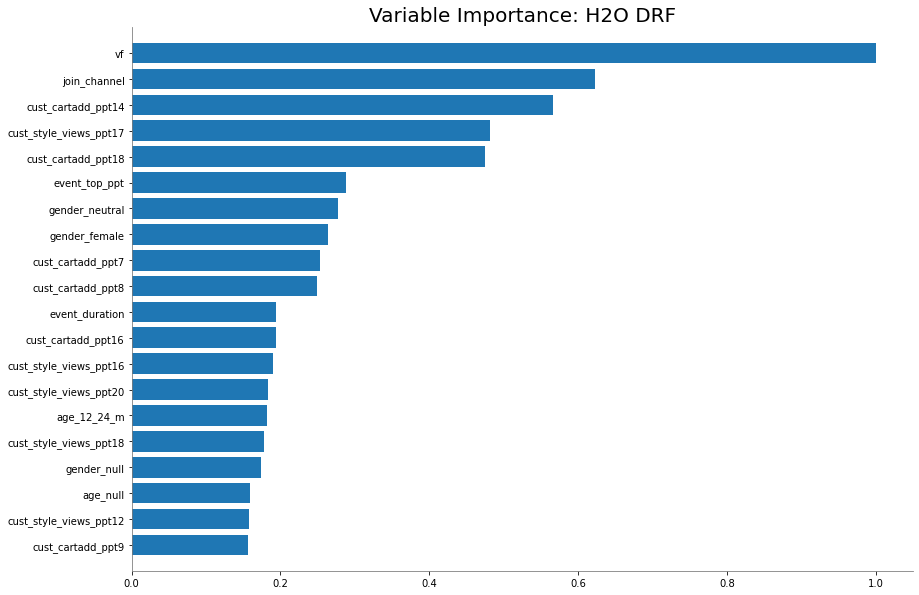

In [301]:
model.varimp_plot(num_of_features=20)

### Load a model from h2o Flow

In [ ]:
# # load a model from h2o cluster if exists
# model=h2o.get_model(model_id='DRF_model_python_1635885713183_48')

In [25]:
# for k in list(model_properties.keys()):
#     print(k + " " + str(model.actual_params[k]))

seed 123
stopping_rounds 0
stopping_tolerance 0.001
stopping_metric AUCPR
ntrees 46
max_depth 20
min_rows 200.0
nbins 20
nbins_cats 100
nfolds 5
keep_cross_validation_models False
categorical_encoding Enum


# Model and Performance Logging

## ModelDB - Model and model artifacts

In [260]:
local_path = "/tmp/plots"
if os.path.exists(local_path):        
    shutil.rmtree(local_path)
os.mkdir(local_path)

#### Log model path

In [ ]:
print("h2o_model_path: ", model_path)
print("h2o_mojo_path: ", mojo_path)

In [208]:
# Logging the model
modeldb_expt_run.log_artifact_path('model_save_path', model_path, overwrite=True)
modeldb_expt_run.log_artifact_path('mojo_save_path', mojo_path, overwrite=True)

#### Log hyperparameters

In [209]:
# Get performance metrics of cross validation and test (valid set) from h2o model
cv_performance = model.model_performance(xval=True)
# test_performance = model.model_performance(valid=True)

In [210]:
# Logs hyperparameter used for model
# run.log_hyperparameter('ntrees', ntrees)
for k, v in model_properties.items():
    modeldb_expt_run.log_hyperparameter(k, v, overwrite=True)

#### Log attributes and artifact

In [211]:
# Attribute can capture a python list as well. Here, X is the list of features
modeldb_expt_run.log_attribute('features', predictors, overwrite=True)
modeldb_expt_run.log_attribute('train_data', TRAIN_BLOB, overwrite=True)
 
# Adding tags to the run so that it is easy to identify the runs
# Tag name can not be more than 40 characters.
modeldb_expt_run.log_tags(EXPERIMENT_RUN_TAGS)

In [212]:
# Table columns and predictors
modeldb_expt_run.log_attribute(
    'columns_and_types', column_and_types,
    overwrite=True
)

In [213]:
# model.varimp(use_pandas=True)[['variable', 'percentage']].sort_values(by='percentage', ascending=False).to_csv("temp.csv")

In [214]:
var_imp_table = model.varimp(use_pandas=True)[['variable', 'percentage']].sort_values(by='percentage', ascending=False)[0:30]
var_imp_table['percentage'] = var_imp_table['percentage'].round(6)*100

upload complete (feature_importance_Plot)


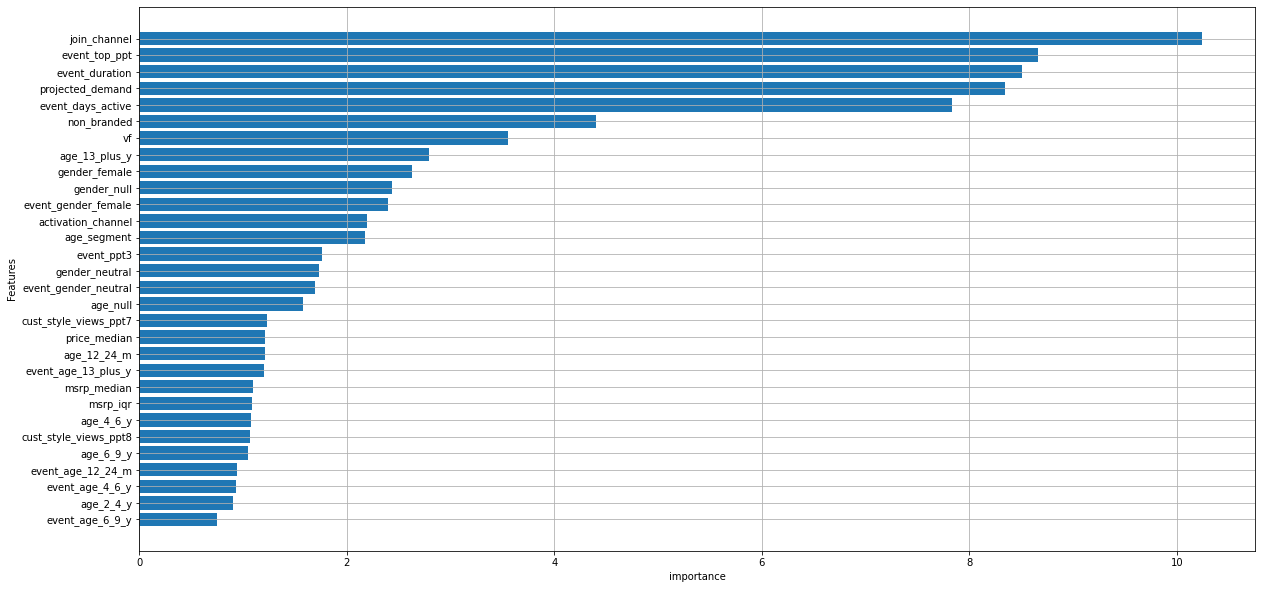

In [215]:
figure = plt.figure(figsize=(20, 10))

plt.barh(y='variable', width='percentage', 
         data=var_imp_table.sort_values(by='percentage', ascending=True))

plt.grid(b=True)
plt.xlabel("importance")
plt.ylabel("Features")
figure = plt.gcf()    
figure.savefig('/tmp/plots/varimp.png')

modeldb_expt_run.log_artifact('feature_importance_Plot', '/tmp/plots/varimp.png', overwrite=True)

In [216]:
# variable importance table
var_imp_table['rank'] = [str(i).rjust(3, '0') for i in range(1, var_imp_table.shape[0]+1)]
var_imp_dict = dict([(row['rank']+'_'+row['variable'], row['percentage']) for _, row in var_imp_table.iterrows()])

modeldb_expt_run.log_attribute(
    'varimp_values', var_imp_dict,
    overwrite=True)

In [219]:
# Logging performance metrics of the run by label
modeldb_expt_run.log_attribute(
    'performance_metrics',
    {
    'cv_error_rate': cv_performance.error(), 
    'cv_logloss': cv_performance.logloss(), 
    'cv_auc': cv_performance.auc(), 
    'cv_aucpr': cv_performance.aucpr(), 
    'cv_precision': cv_performance.precision(), 
    'cv_recall': cv_performance.recall(), 
    'cv_f1': cv_performance.F1(), 
    'cv_f0point5': cv_performance.F0point5(), 
    
#     'test_error_rate': test_performance.error(), 
#     'test_logloss': test_performance.logloss(), 
#     'test_auc': test_performance.auc(), 
#     'test_precision': test_performance.precision(), 
#     'test_recall': test_performance.recall(), 
#     'test_f1': test_performance.F1(), 
#     'test_f0point5': test_performance.F0point5(),
    },
    overwrite=True
)
 

#### Log performance metrics

In [220]:
# Performance metrics available from H2O Model
perf_metrics = [
    'error',
    'logloss', 
    'auc', 
    'precision', 
    'recall', 
    'f1', 
    'f0point5', 
    'mean_per_class_accuracy'
]

In [221]:
# Logging performance metrics of the run
modeldb_expt_run.log_metrics({
    'cv_logloss': cv_performance.logloss(), 
    'cv_auc': cv_performance.auc(), 
    'cv_aucpr': cv_performance.aucpr(), 
    'cv_gini': cv_performance.gini(), 
    
#     'test_logloss': test_performance.logloss(), 
#     'test_auc': test_performance.auc(), 
#     'test_aucpr': test_performance.aucpr(), 
#     'test_gini': test_performance.gini()
}, overwrite=True)
 

#### Log observation

In [222]:
# Logging cross_validation metrics as observations
# This will also allow you to visualize the change of metrics across differernt folds
cv_df = model.cross_validation_metrics_summary().as_data_frame()
cv_df.rename(columns={'':'metrics'}, inplace=True)
cv_columns = [f'cv_{i}_valid' for i in range(1, model_properties['nfolds']+1)]

# Looping through cross-validation metrics and logging it as observations.
# Logging it as observations allows us to visualize the metrics as chart in the UI.
for metric in ['logloss', 'auc']:
    for col in cv_columns:
        modeldb_expt_run.log_observation(
            'cv_' + metric, 
            float(cv_df[cv_df.metrics==metric][col].values[0]),
            overwrite=False
        )
 

## Model Evaluation - Prediction and Performance Metrics

### Load Test data (test data set)

In [17]:
# temp = pd.read_csv("gs://zulilymodeltraining/rmenon/data/test/all_features_text_test_v6000000000000.csv", nrows=5)

In [170]:
# #Manual Load of a Valid data (test data set)
# TEST_BLOB = "gs://jskim/model_h4/data/tf_classification_v07__v4/test/all_features_test_tf_classification_v07_test_diff__v4/all_features_test_tf_classification_v07_test_diff__v4_champion"

In [302]:
print(TEST_CHAMPION_BLOB)

gs://jskim/model_h4/data/tf_classification_v07__v4/test/all_features_test_tf_classification_v07_test_diff__v4_champion/all_features_test_tf_classification_v07_test_diff__v4_champion


#### Define column types

In [303]:
columns, col_types = get_column_types_from_data_blob(
#     blob_path=TEST_BLOB, 
    blob_path =TEST_CHAMPION_BLOB,
    pattern= '.*0000000\.csv', 
    string_columns=STRING_COLS,
#     NUMERICAL_COLS=NUMERICAL_COLS,
    numerical_columns=NUMERICAL_COLS + ['predict'], # for champion test
    categorical_columns='',
    default_type='categorical'
)

column_and_types = dict(zip(columns, col_types))

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Loading test data

In [304]:
# Load test data

st=time.time()

# test_all = h2o.import_file(path=TEST_BLOB, pattern= '.*\.csv', col_types=col_types)

# # Genneral test
# test = h2o.import_file(path=TEST_BLOB, pattern= '.*\.csv', col_types=col_types)
# Champion test
test = h2o.import_file(path=TEST_CHAMPION_BLOB, pattern= '.*\.csv', col_types=col_types)

duration = (time.time() - st)/60
logger.info("data loading takes {:.1f} min".format(duration))

Parse progress: |█████████████████████████████████████████████████████████| 100%


2022-02-08 20:10:14,846 - INFO - data loading takes 0.1 min


In [305]:
test.shape

(1473429, 167)

In [64]:
### Filter test data
# NT segment: NT events
# test = test_all[test_all['is_nt_event']=="0"]

# NT segment: Live events
# train = train[train['is_nt_event']=="0"]

##### Select sample test data

In [261]:
# sample_customers = test_raw[0:100, ['customer_id']].asnumeric().unique().asfactor()
# sample_customers.set_names(['customer_id'])
# sample_customers.shape

(100, 1)

In [262]:
# test_raw['customer_id'] = test_raw['customer_id'].asfactor()
# test = test_raw.merge(sample_customers, all_x=False, all_y=False)
# test['customer_id'] = test['customer_id'].ascharacter()
# test.shape

(21118, 129)

#### Test data set: Label setting

In [306]:
# test label settings
test[test[RESPONSE_COL].isin(POSITIVE_LABELS), RESPONSE_COL] = '1'
test[test[RESPONSE_COL].isin(NEGATIVE_LABELS), RESPONSE_COL] = '0'

test[RESPONSE_COL] = test[RESPONSE_COL].asfactor()

### Load Champion Prediction
- champion scores: champion_prediction_20210831_20210930_all
- chmpion source table: `massive-clone-705.model_output.model_output_no_domain_conversioncspo_ned_201808_201904_null_*`
- target table: `zulilymodeltraining.greenfield.tf_classification_test_targets_v04_all_imp`
- periods: from 2021-08-31 to 2021-09-30
- table_view of all champion: `zulilymodeltraining.jskim_model_data.champion_prediction_20210831_20210930_data`
- table view of joinng champion and target_test: `zulilymodeltraining.jskim_model_data.test_target_v04_all_imp_champion_prediction_data`

In [150]:
# %%bigquery champion_scores
# SELECT customer_id, send_date, event_id, predict_champion
# FROM `zulilymodeltraining.jskim_model_data.test_target_v04_all_imp_champion_prediction_data`

Downloading: 100%|██████████| 1473429/1473429 [00:03<00:00, 449303.49rows/s] 


In [151]:
# champion_scores.head(2)

,customer_id,send_date,event_id,predict_champion,champion
0,76826391,2021-08-31,509797,0.0012014651298523082,1
1,76826391,2021-08-31,519520,0.00098797559738161844,1


In [174]:
# champion_customers = champion_scores[['customer_id']].drop_duplicates().customer_id.tolist()

### Predict Test data set

##### Predictions

In [307]:
%%time
test_pred = model.predict(test_data=test)
# test = model.predict(test_data=test)

drf prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.8/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'event_age_null' has levels not trained on: [0.4, 0.46]
  warnings.warn(w)
/opt/conda/lib/python3.8/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'event_gender_null' has levels not trained on: [0.4, 0.41]
  warnings.warn(w)


CPU times: user 477 ms, sys: 13.9 ms, total: 491 ms
Wall time: 3.54 s


In [308]:
test_pred.shape

(1473429, 3)

##### Converting predictions

In [120]:
# # Get predicted labels for new data
# pred_results = test[['customer_id','send_date', 'event_id', 'event_name', 'is_nt_event', 'is_branded_event', 'label']].cbind(test_pred)

In [309]:
# Get predicted labels for new data - Champion prediction
pred_results = test[['customer_id','send_date', 'event_id', 'event_name', 'is_nt_event', 'is_branded_event', 'label','predict']]
pred_results['predict_champion'] = pred_results['predict']
pred_results = pred_results.drop('predict')
pred_results = pred_results.cbind(test_pred)

In [310]:
%%time
# Convert h2o frame of the predicted result to pandas dataframe
# multi GB will cause too much delay => manualy save to CSV from H2O Flow and import to pandas
# pred_results_df =pred_results[0:100,:].as_data_frame()
# pred_results_df =h2o.as_list(pred_results[0:100,:])
# pred_results_df = h2o.as_list(
#     pred_results[pred_results['customer_id'].isin(sample_customers), :]
# )

# pred_results_df = h2o.as_list(
#     pred_results[pred_results['send_date'].isin(['2021-09-24', '2021-09-25', '2021-09-26']), :]
# )

pred_results_df = h2o.as_list(pred_results)


CPU times: user 8min 10s, sys: 9.94 s, total: 8min 20s
Wall time: 8min 27s


In [312]:
pred_results_df.shape

(1473429, 11)

In [313]:
# Get true labels for new data
# convert labes and predictions to numpy array
# true labels
true_labels = pred_results_df['label'].to_numpy()
# predicted labels
pred_indices = pred_results_df['predict'].to_numpy()
# prediction scores
pred_indices_raw = pred_results_df['p1'].to_numpy()

In [314]:
# Select customer and send date with minimum number of events in the sort. 
pred_results_df['events_count'] = pred_results_df.groupby(['customer_id', 'send_date'])[['event_id']].transform('count')

model_results_df = pred_results_df[pred_results_df.events_count >= 20].copy()
model_results_df.head()

,customer_id,send_date,event_id,event_name,is_nt_event,is_branded_event,label,predict_champion,predict,p0,p1,events_count
0,9133314,2021-09-05,442499,martha stewart: shop all,0,0,1,0.005585,1,0.044256,0.955744,97
1,100014254,2021-09-08,442499,martha stewart: shop all,0,0,0,0.003147,1,0.203832,0.796168,38
2,73913386,2021-09-23,468693,plus & more,0,0,0,0.006101,1,0.069663,0.930337,120
3,84263892,2021-09-23,468693,plus & more,0,0,1,0.004463,1,0.266840,0.733160,175
4,7284130,2021-09-22,468693,plus & more,1,0,0,0.002476,1,0.080025,0.919975,80


In [315]:
model_results_df.shape

(1359029, 12)

### Model Performance Evaluation

In [316]:
# Parameters for Hit Rate and NDCG metrics
MAX_RANK = 20
Evaluation_Rank = [10]
CHAMPION_SCORE_COL = 'predict_champion'
MODEL_SCORE_COL = 'p1'

In [317]:
RESPONSE_COL

'label'

#### LTR and NDCG of the Champion Model

In [318]:
# Call the function to evaluate LTR metrics
champion_model_hit_rate_df = pd.DataFrame()
champion_model_ndcg_df = pd.DataFrame()

for  date, g_df in model_results_df.groupby('send_date'):
    model_hit_rate, model_ndcg = evaluation_utilities.get_ltr_metrics(
                                        model_results_df=g_df,
                                        K=MAX_RANK,
                                        target_column=RESPONSE_COL,
                                        score_column=CHAMPION_SCORE_COL)
    for kk in range(1,len(model_hit_rate)+1):
        champion_model_hit_rate_df.loc[date, f'champion_model_hit_rate_k_{kk}'] = model_hit_rate[kk-1]
        champion_model_ndcg_df.loc[date, f'champion_model_ndcg_k_{kk}'] = model_ndcg[kk-1]

champion_model_hit_rate_df.index = pd.to_datetime(model_hit_rate_df.index)
champion_model_ndcg_df.index = pd.to_datetime(model_ndcg_df.index)

ValueError: Length mismatch: Expected axis has 31 elements, new values have 3 elements

#### LTR and NDCG of the Trained Model

In [ ]:
# Evaluating LTR performance metrics
MAX_RANK = 20
Evaluation_Rank = [19]

# Call the function to evaluate LTR metrics
model_hit_rate_df = pd.DataFrame()
model_ndcg_df = pd.DataFrame()
for  date, g_df in model_results_df.groupby('send_date'):
    model_hit_rate, model_ndcg = evaluation_utilities.get_ltr_metrics(
                                        model_results_df=g_df,
                                        K=MAX_RANK,
                                        target_column=RESPONSE_COL,
                                        score_column=MODEL_SCORE_COL)
    for kk in range(1,len(model_hit_rate)+1):
        model_hit_rate_df.loc[date, f'model_hit_rate_k_{kk}'] = model_hit_rate[kk-1]
        model_ndcg_df.loc[date, f'model_ndcg_k_{kk}'] = model_ndcg[kk-1]

model_hit_rate_df.index = pd.to_datetime(model_hit_rate_df.index)
model_ndcg_df.index = pd.to_datetime(model_ndcg_df.index)

#### Plotting LTR and NDCG of the Champion and Trained Model

In [ ]:
# Select rank columns to plot
hit_cols = \
    [f'champion_model_hit_rate_k_{kk}' for kk in Evaluation_Rank] + \
    [f'model_hit_rate_k_{kk}' for kk in Evaluation_Rank]

ngcg_cols = \
    [f'champion_model_ndcg_k_{kk}' for kk in Evaluation_Rank] + \
    [f'model_ndcg_k_{kk}' for kk in Evaluation_Rank]

In [ ]:
# merge champion and trained model hit and ndcg metrics
all_model_hit_rate_df = pd.concat([champion_model_hit_rate_df, model_hit_rate_df], axis=1)[hit_cols]
all_model_ndcg_df = pd.concat([champion_model_ndcg_df, model_ndcg_df], axis=1)[ngcg_cols]

In [ ]:
def plot_hitrate(df, save=False, log_artifact=False):
    figure = plt.figure(figsize=(8, 5))
    max_val = df.max().max()
    
    for col in df.columns:
        plt.plot(df[col], '*-', label=col)

    plt.ylabel('HR@K')
    plt.xlabel('Dates')
    plt.legend()
    plt.grid(b=True)
    
    plt.ylim(0, max_val+0.5)

    dtFmt = mdates.DateFormatter('%d\n%b') # define the formatting
    plt.gca().xaxis.set_major_formatter(dtFmt)
    
    if save:
        figure = plt.gcf()    
        figure.savefig('/tmp/plots/hitrate.png')
        
    if log_artifact:
        modeldb_expt_run.log_artifact('Hit_Rate_Plot', '/tmp/plots/hitrate.png', overwrite=True)

In [ ]:
plot_hitrate(all_model_hit_rate_df, save=False, log_artifact=False)

In [ ]:
def plot_ndcg(df, save=False, log_artifact=False):
    figure = plt.figure(figsize=(8, 5))

    for col in df.columns:
        plt.plot(df[col], '*-', label=col)

    plt.ylabel('NDCG@K')
    plt.xlabel('Dates')
    plt.legend()
    plt.grid(b=True)
    
    plt.ylim(0, 1)

    dtFmt = mdates.DateFormatter('%d\n%b') # define the formatting
    plt.gca().xaxis.set_major_formatter(dtFmt)

    if save:
        figure = plt.gcf()    
        figure.savefig('/tmp/plots/ndcg.png')
        
    if log_artifact:
        modeldb_expt_run.log_artifact('NDCG_Plot', '/tmp/plots/ndcg.png', overwrite=True)

In [ ]:
plot_ndcg(df=all_model_ndcg_df, save=False, log_artifact=False)

In [287]:
print(classification_report(true_labels, pred_indices, target_names = TARGET_NAMES, zero_division = 0))
cr = classification_report(true_labels, pred_indices, target_names = TARGET_NAMES, zero_division=0, output_dict = True)
class_0_recall = np.around(cr['class 0']['recall'], decimals=5)
class_1_recall = np.around(cr['class 1']['recall'], decimals=5)

              precision    recall  f1-score   support

     class 0       0.95      0.05      0.10    135090
     class 1       0.13      0.98      0.23     20078

    accuracy                           0.17    155168
   macro avg       0.54      0.52      0.17    155168
weighted avg       0.84      0.17      0.11    155168



              precision    recall  f1-score   support

     class 0       0.95      0.05      0.10    135090
     class 1       0.13      0.98      0.23     20078

    accuracy                           0.17    155168
   macro avg       0.54      0.52      0.17    155168
weighted avg       0.84      0.17      0.11    155168

upload complete (ROC)
upload complete (PR)
upload complete (confusion_matrix)
upload complete (confusion_matrix_normalized)


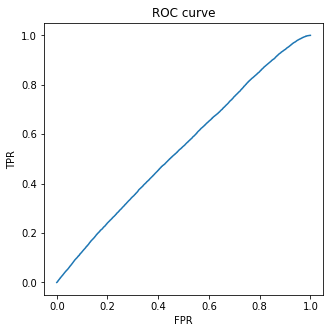

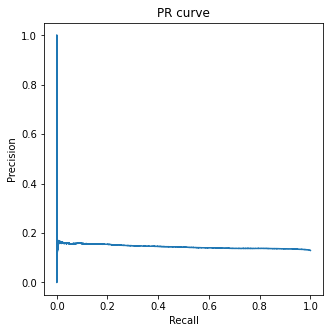

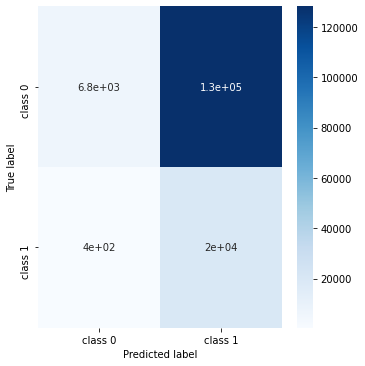

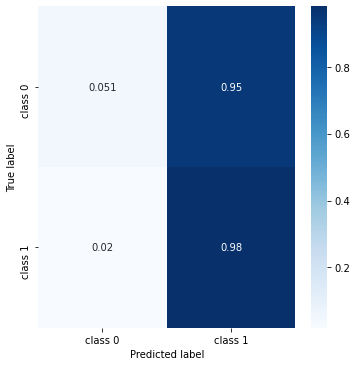

In [288]:
# Print Some Performance Metrics
print(classification_report(true_labels, pred_indices, target_names = TARGET_NAMES, zero_division = 0))
cr = classification_report(true_labels, pred_indices, target_names = TARGET_NAMES, zero_division=0, output_dict = True)
class_0_recall = np.around(cr['class 0']['recall'], decimals=5)
class_1_recall = np.around(cr['class 1']['recall'], decimals=5)
modeldb_expt_run.log_metrics({'Recall_Class_0': class_0_recall, 'Recall_Class_1': class_1_recall, }, overwrite=True)

# Create ROC curve
figure = plt.figure(figsize=(5, 5))
fpr, tpr, thresholds = roc_curve(true_labels, pred_indices_raw)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('/tmp/plots/roc.png')
modeldb_expt_run.log_artifact('ROC', '/tmp/plots/roc.png', overwrite=True)

# Create PR curve
figure = plt.figure(figsize=(5, 5))
precision, recall, thresholds = precision_recall_curve(true_labels, pred_indices_raw)
plt.plot(recall, precision)
plt.title('PR curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('/tmp/plots/pr.png')
modeldb_expt_run.log_artifact('PR', '/tmp/plots/pr.png', overwrite=True)

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_indices)
cm_df = pd.DataFrame(cm, index = TARGET_NAMES, columns = TARGET_NAMES)
cm_normalize_df = pd.DataFrame(normalize(cm, 'l1', axis = 1), index = TARGET_NAMES, columns = TARGET_NAMES)
figure = plt.figure(figsize=(5, 5))
svm = sns.heatmap(cm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure = svm.get_figure()    
figure.savefig('/tmp/plots/cm.png')

figure = plt.figure(figsize=(5, 5))
svm = sns.heatmap(cm_normalize_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure = svm.get_figure()    
figure.savefig('/tmp/plots/cm_norm.png')

# Saving confusion_matrix
modeldb_expt_run.log_artifact('confusion_matrix', '/tmp/plots/cm.png', overwrite=True)
modeldb_expt_run.log_artifact('confusion_matrix_normalized', '/tmp/plots/cm_norm.png', overwrite=True)
